In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn for Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
# import sklearn for Cross Validation
from sklearn.model_selection import train_test_split  
# import sklearn  for Evaluation
from sklearn.metrics import accuracy_score , plot_confusion_matrix , classification_report , roc_auc_score
# import sklearn  for Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

1. Read Dataset


In [2]:
# Read csv files into a pandas dataframe
df_star = pd.read_csv("star_classification.csv")
#display first 5 rows from dataset
df_star.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


##### The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

1. `obj_ID `= Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. `alpha` = Right Ascension angle (at J2000 epoch)
3. `delta` = Declination angle (at J2000 epoch)
4. `u` = Ultraviolet filter in the photometric system
5. `g` = Green filter in the photometric system
6. `r` = Red filter in the photometric system
7. `i` = Near Infrared filter in the photometric system
8. `z` = Infrared filter in the photometric system
9. `run_ID` = Run Number used to identify the specific scan
10. `rereun_ID` = Rerun Number to specify how the image was processed
11. `cam_col` = Camera column to identify the scanline within the run
12. `field_ID` = Field number to identify each field
13. `spec_obj_ID` = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. `class` = object class (galaxy, star or quasar object)
15. `redshift` = redshift value based on the increase in wavelength
16. `plate` = plate ID, identifies each plate in SDSS
17. `MJD` = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. `fiber_ID` = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation
Citation

Here, the target column is `class` so it's a multiclass classification problem with three variables `galaxy`, `star` or `quasar `


In [3]:
#select the most interesting columns from dataset
interesting_columns = [
    'alpha', 'delta', 
    'u', 'g', 'r', 'i', 
    'z','class','redshift'
]
df_star = pd.DataFrame(df_star, columns=interesting_columns)

In [4]:
#rename dataset columns
df_star.rename(columns={
    'u': 'ultr_filter', 
    'g': 'green_filter',
    'r': 'red_filter', 
    'i': 'near_infrared_filter',
    'z' : 'infrared_filter'}, inplace=True
)

2. Exploratory Data Analysis and preprocessing

In [5]:
#check the dataset features types and shape
df_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   alpha                 100000 non-null  float64
 1   delta                 100000 non-null  float64
 2   ultr_filter           100000 non-null  float64
 3   green_filter          100000 non-null  float64
 4   red_filter            100000 non-null  float64
 5   near_infrared_filter  100000 non-null  float64
 6   infrared_filter       100000 non-null  float64
 7   class                 100000 non-null  object 
 8   redshift              100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


From dataset description, we can see that:
1. The shape (100000, 9).
2. There are no missing values.

In [6]:
#Any duplicated rows ?
df_star.duplicated().sum()

0

In [7]:
#descriptive statistics for dataset
df_star.describe()

,alpha,delta,ultr_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


In [8]:
#check rows with -9999.000000 values in ultr_filter and green_filter
df_star[df_star['ultr_filter'] == -9999.000000	]

,alpha,delta,ultr_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,class,redshift
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [9]:
#drop row with -9999.000000 values in ultr_filter and green_filter
df_star.drop(df_star.index[df_star.ultr_filter == -9999.000000	 ] ,inplace=True)

GALAXY    0.594456
STAR      0.215932
QSO       0.189612
Name: class, dtype: float64


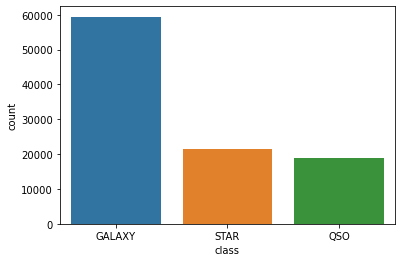

In [10]:
#check the values and its percentage in target column
print(df_star['class'].value_counts(normalize=True))
sns.countplot(df_star['class'],order = df_star['class'].value_counts().index);


We have approximately 60% galaxy, 21% star, and 19% QSO in the dataset so our data suffer from an imbalance target values


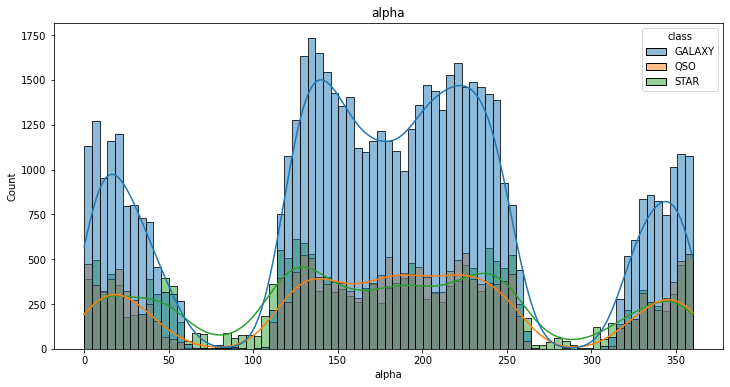

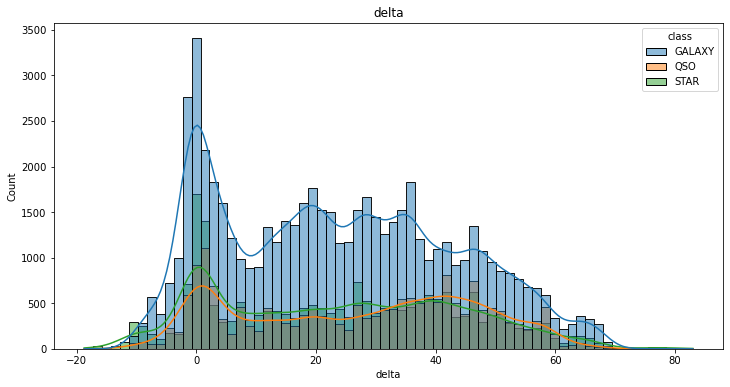

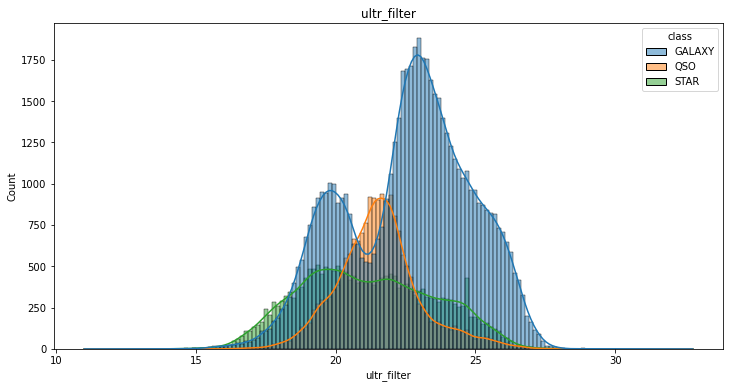

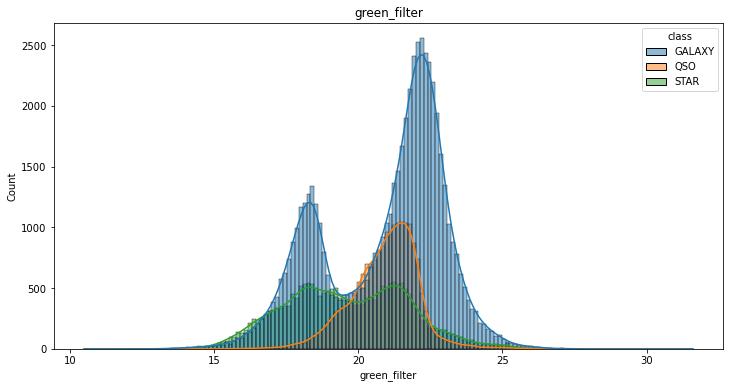

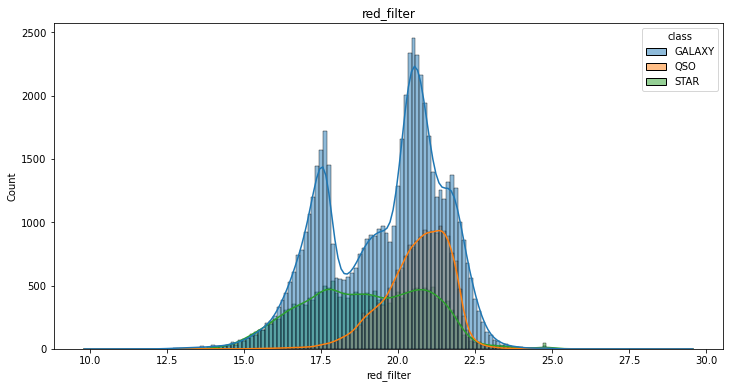

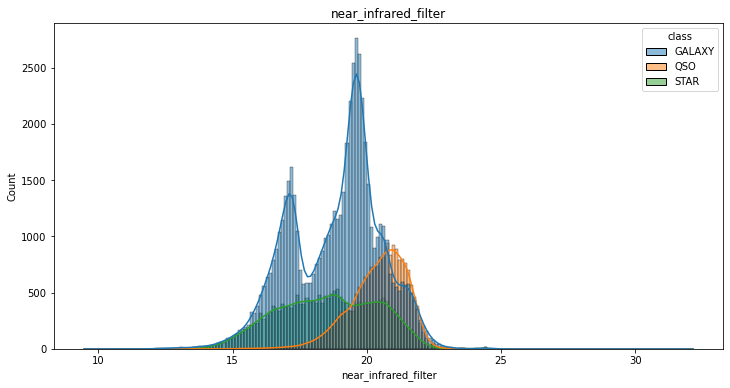

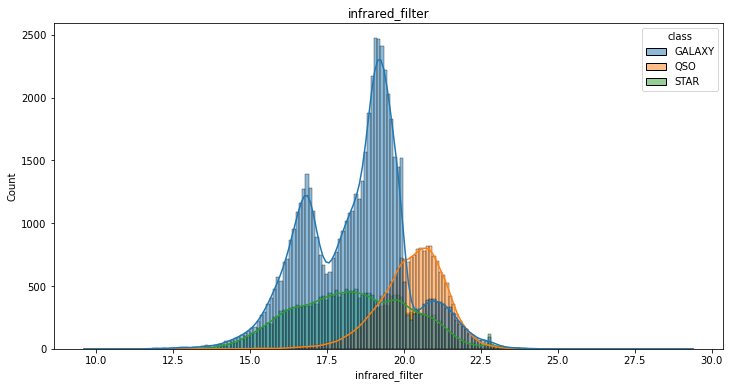

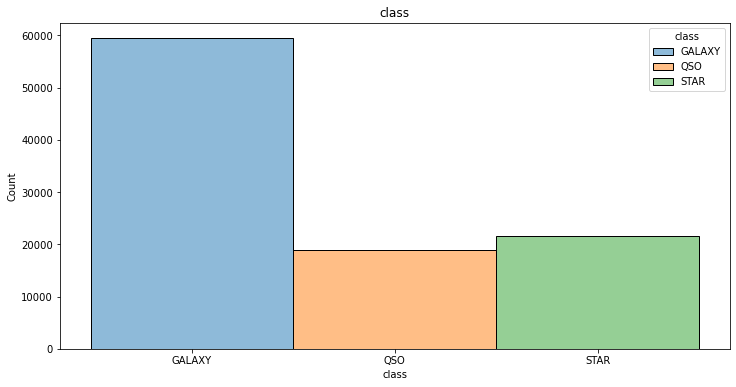

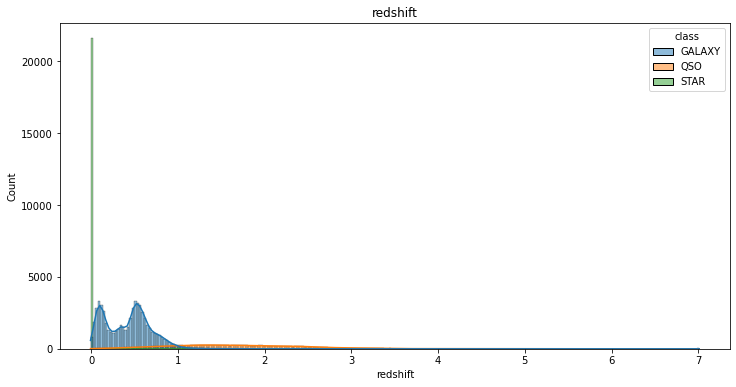

In [11]:
#check distrbution with class
for column in df_star.columns:
    plt.figure(figsize=(12,6))
    sns.histplot(data=df_star, x=column, kde=True, hue="class")
    plt.title(column)
    plt.show()

In [12]:
map_labels = {"GALAXY" :0,
               "STAR" :1,   
                "QSO": 2,
}

df_star["class"] = df_star["class"].map(map_labels)

3. Split Dataset into Train and Test Data

In [13]:
# scaled and separating dataset to data  and target_labels
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_star.drop(['class'], axis=1)))
y = df_star['class']


In [14]:
# Split the data in train/val/test sets, with 60%/20%/20% distribution
X_train_val, X_test, y_train_val, y_test  = train_test_split(X, y, test_size=0.20, random_state=1) 
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) 


4. Model Training


4.1 Base Ensamble model

4.1.1 RandomForestClassifier Model

Validation dataset ACC: 0.9756
Validation dataset ROC_AUC_SCORE : 0.9939
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11838
           1       1.00      1.00      1.00      4289
           2       0.96      0.92      0.94      3873

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



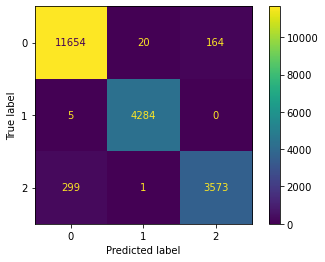

In [15]:
# Train the model with training dataset 
rf_base = RandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1)
rf_base_model = rf_base.fit(X_train,y_train)
# Predict using validation dataset
y_pred = rf_base_model.predict(X_val)
y_score = rf_base_model.predict_proba(X_val)
#validation dataset score
print("Validation dataset ACC: %0.4f" % rf_base_model.score(X_val,y_val))
#validation dataset roc_auc_score
print("Validation dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_val, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_val, y_pred))
# Confusion Matrix
plot_confusion_matrix(rf_base_model,X_val,y_val);

4.2 Random Undersampling


Validation dataset ACC: 0.9720
Validation dataset ROC_AUC_SCORE : 0.9946
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11838
           1       0.99      1.00      1.00      4289
           2       0.92      0.94      0.93      3873

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



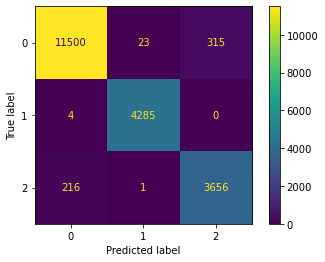

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1))
model = undersample_pipe.fit(X_train,y_train)
# Predict using validation dataset
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)
#validation dataset score
print("Validation dataset ACC: %0.4f" % model.score(X_val,y_val))
#validation dataset roc_auc_score
print("Validation dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_val, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_val, y_pred))
# Confusion Matrix
plot_confusion_matrix(model,X_val,y_val);

4.3 Random Oversampling


Validation dataset ACC: 0.9756
Validation dataset ROC_AUC_SCORE : 0.9937
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11838
           1       1.00      1.00      1.00      4289
           2       0.95      0.93      0.94      3873

    accuracy                           0.98     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



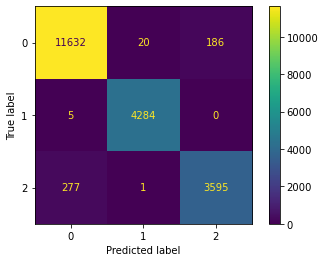

In [17]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1))
model = oversample_pipe.fit(X_train,y_train)
# Predict using validation dataset
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)
#validation dataset score
print("Validation dataset ACC: %0.4f" % model.score(X_val,y_val))
#validation dataset roc_auc_score
print("Validation dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_val, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_val, y_pred))
# Confusion Matrix
plot_confusion_matrix(model,X_val,y_val);

4.4 Class Weights


Validation dataset ACC: 0.9760
Validation dataset ROC_AUC_SCORE : 0.9937
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11838
           1       1.00      1.00      1.00      4289
           2       0.96      0.92      0.94      3873

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



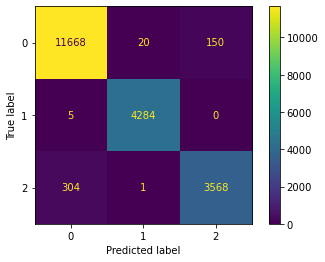

In [18]:
rf_wei = RandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1, class_weight='balanced')
model = rf_wei.fit(X_train,y_train)
# Predict using validation dataset
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)
#validation dataset score
print("Validation dataset ACC: %0.4f" % model.score(X_val,y_val))
#validation dataset roc_auc_score
print("Validation dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_val, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_val, y_pred))
# Confusion Matrix
plot_confusion_matrix(model,X_val,y_val);

4.5 Resampled Ensembles


Validation dataset ACC: 0.9710
Validation dataset ROC_AUC_SCORE : 0.9946
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11838
           1       0.99      1.00      1.00      4289
           2       0.92      0.94      0.93      3873

    accuracy                           0.97     20000
   macro avg       0.96      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



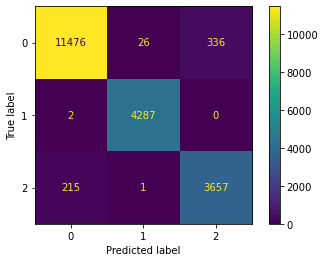

In [19]:
resampled_rf = BalancedRandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1)
model = resampled_rf.fit(X_train,y_train)
# Predict using validation dataset
y_pred = model.predict(X_val)
y_score = model.predict_proba(X_val)
#validation dataset score
print("Validation dataset ACC: %0.4f" % model.score(X_val,y_val))
#validation dataset roc_auc_score
print("Validation dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_val, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_val, y_pred))
# Confusion Matrix
plot_confusion_matrix(model,X_val,y_val);

5. Predict on Test Dataset


Test dataset ACC: 0.9749
Test dataset ROC_AUC_SCORE : 0.9955
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11836
           1       0.99      1.00      1.00      4369
           2       0.92      0.95      0.94      3795

    accuracy                           0.97     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.97      0.98     20000



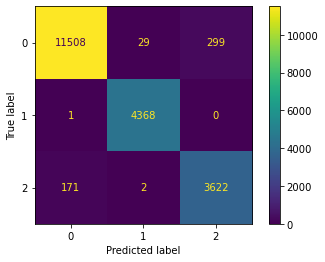

In [20]:
resampled_rf = BalancedRandomForestClassifier(n_estimators=50 , criterion="entropy", random_state=1, max_features=3, min_samples_leaf=1)
model = resampled_rf.fit(X_train_val,y_train_val)
# Predict using validation dataset
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
#validation dataset score
print("Test dataset ACC: %0.4f" % model.score(X_test,y_test))
#validation dataset roc_auc_score
print("Test dataset ROC_AUC_SCORE : %0.4f" % roc_auc_score(y_test, y_score, multi_class='ovo'))
# Print a classification report
print(classification_report(y_test, y_pred))
# Confusion Matrix
plot_confusion_matrix(model,X_test,y_test);